In [11]:
from toolbox import *
from music21 import *
import time

In [38]:
file = converter.parse('bach-air-score.mid')
file.show('text')

{0.0} <music21.stream.Part 0x7f5a1f592e20>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Instrument ''>
        {0.0} <music21.instrument.Violin 'Violin'>
        {0.0} <music21.instrument.Violin 'violin'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark largamente Quarter=30.0>
        {0.0} <music21.key.Key of D major>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note F#>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.stream.Voice 0x7f5a18dc0310>
            {0.0} <music21.note.Note F#>
            {0.5} <music21.note.Note B>
            {0.75} <music21.chord.Chord G5 F#5>
            {1.0} <music21.note.Note E>
            {1.25} <music21.note.Note D>
            {1.5} <music21.note.Note C#>
            {1.75} <music21.note.Note D>
            {2.0} <music21.note.Note C#>
            {3.0} <music21.note.Note B>
            {3.25} <music21.note.Rest dotted-eigh

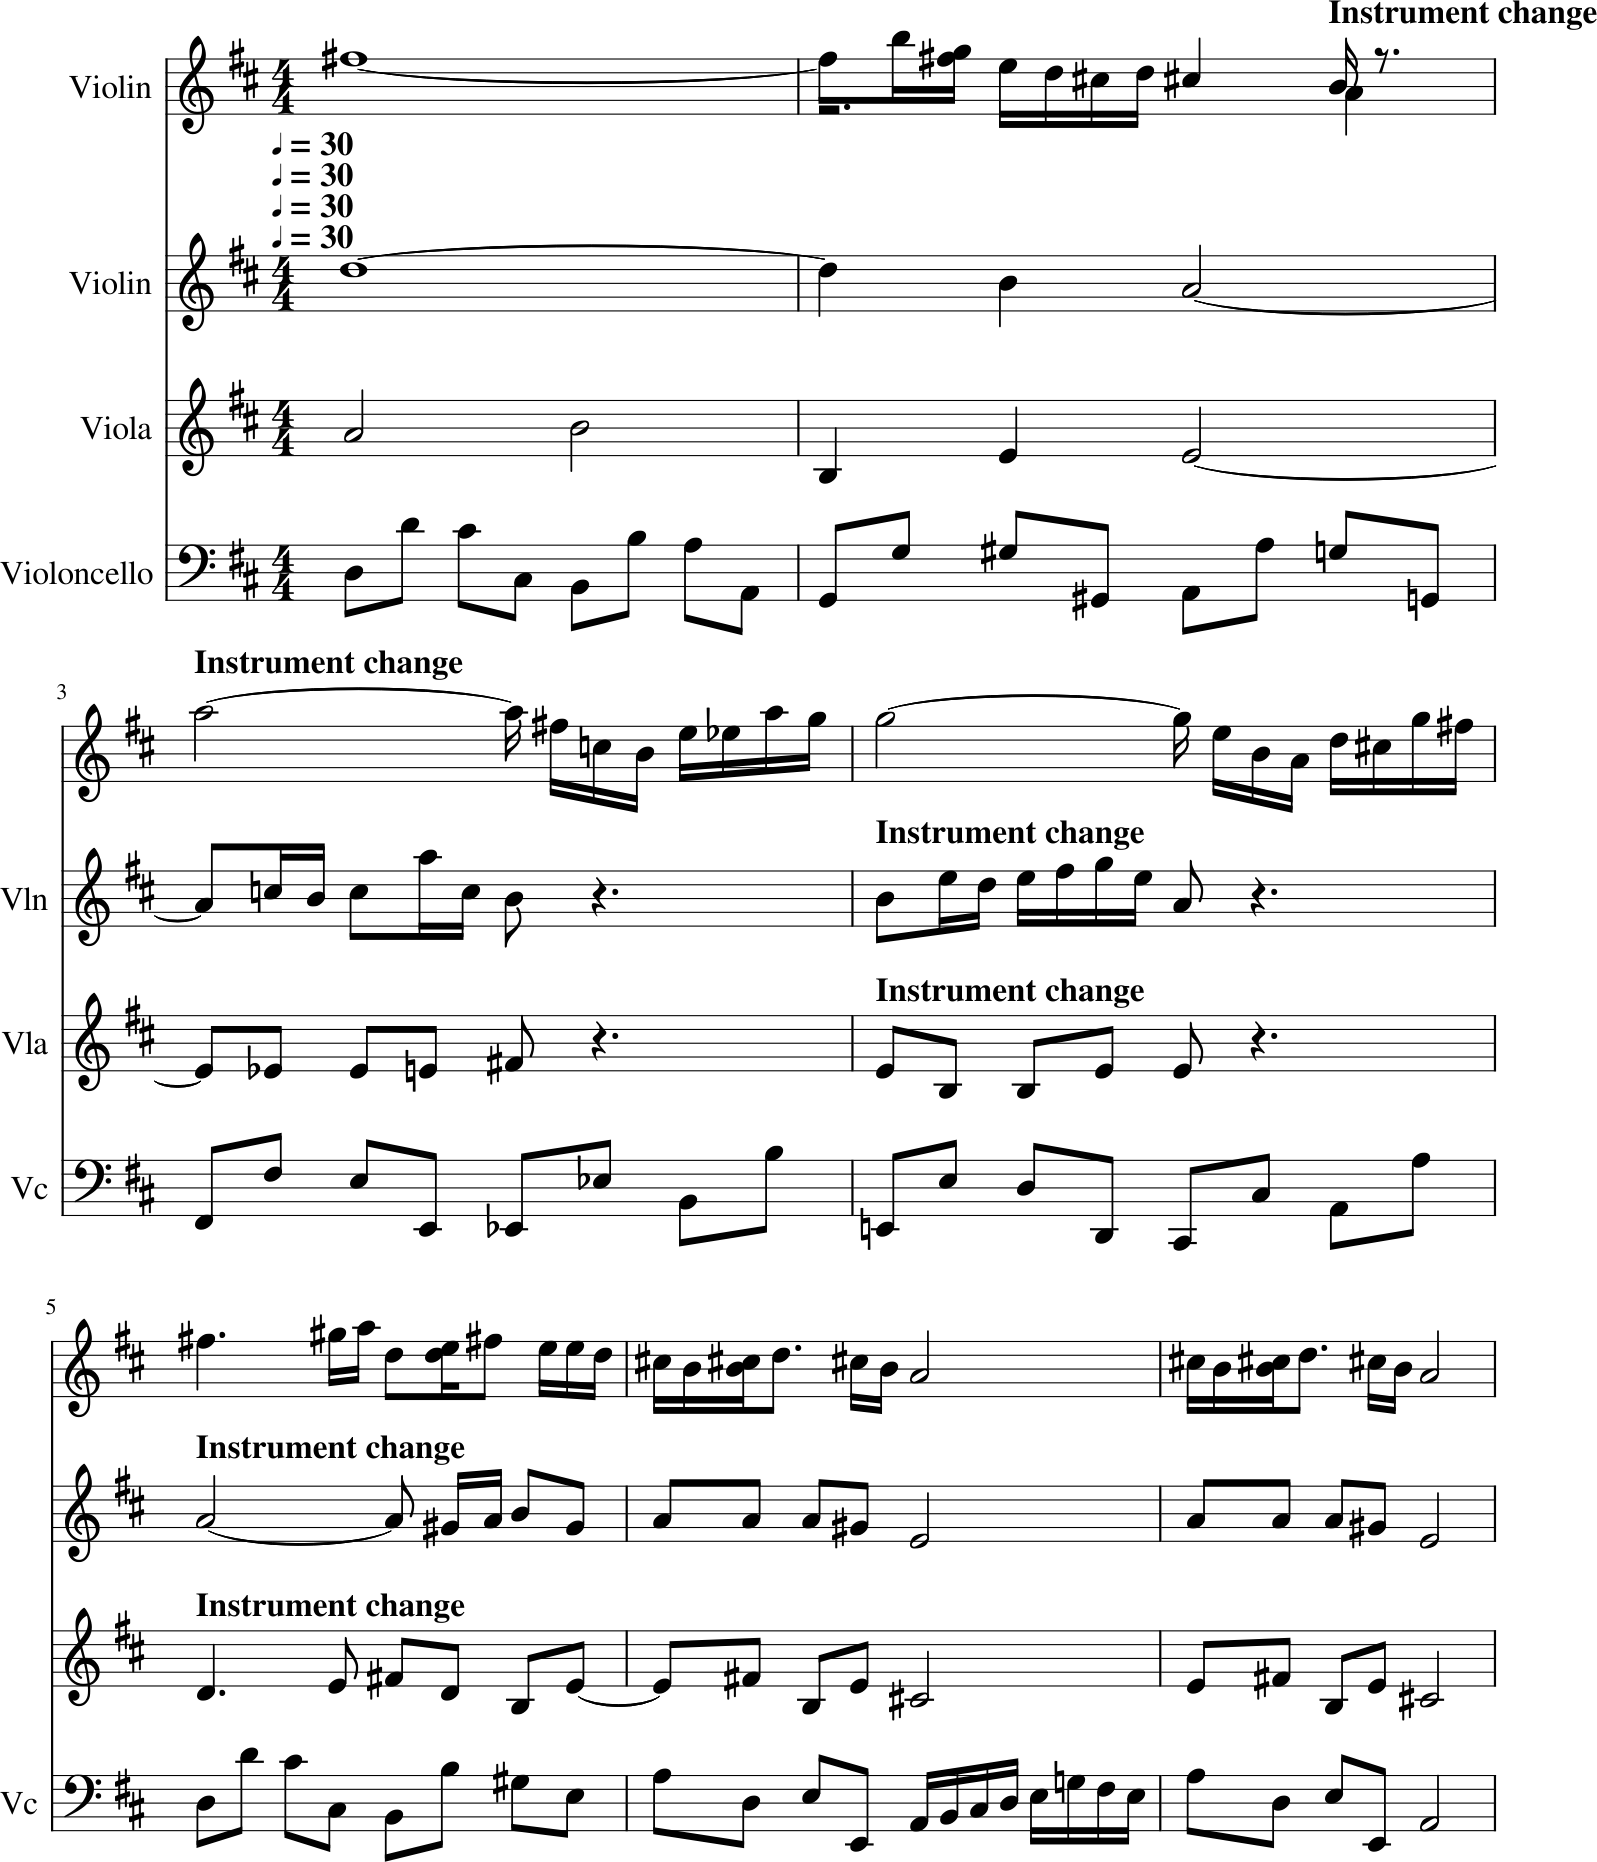

In [37]:
# file.parts[3].measure(77).show()
file.show()

In [14]:
def get_entropy_from_measure(file,track,measure):
    E_p = get_pitches(file.measure(measure).parts[track])
    E_r = get_rhythm(file.measure(measure).parts[track])
    E_s = get_rests(file.measure(measure).parts[track])
    total_entropy = get_list_entropy(E_p) + get_list_entropy(E_r)+ get_list_entropy(E_s)
    return total_entropy

In [44]:
file.measure(1).parts[2].show('text')

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Instrument ''>
    {0.0} <music21.instrument.Viola 'Viola'>
    {0.0} <music21.instrument.Viola 'viola'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark largamente Quarter=30.0>
    {0.0} <music21.key.Key of D major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note A>
    {2.0} <music21.note.Note B>


In [70]:
for a in file.parts[2].measure(1).getElementsByClass(tempo.MetronomeMark):
    print(type(a))
# for a in file.parts[2].measure(1).getElementsByClass(tempo.MetronomeMark):
#     print(a.referent.type)
'MetronomeMark' in a.classes

<class 'music21.tempo.MetronomeMark'>


True

In [19]:
def max_num_measures(file):
    return max([len(p) for p in file.parts])    

def get_entropy_dict(file):
    entropy_dict = {}
    for j in range(1,max_num_measures(file)+1):
        for i in range(len(file.parts)):
            if file.parts[i].measure(j) != None:
                entropy_dict[i,j] = get_entropy_from_measure(file,i,j)
    return entropy_dict

t0= time.time()
entropy_dict = get_entropy_dict(file)
t1 = time.time() - t0
print(t1)

1.106907606124878


In [20]:
from pyqubo import Binary, Constraint

def max_num_measures(file):
    return max([len(p) for p in file.parts])    

def qubo_form_from(entropy_dict):
    H = 0
    for j in range(1,max_num_measures(file)+1):
        c = 0
        o = 0
        for i in range(len(file.parts)):
            if (i,j) in entropy_dict.keys():
                c += Binary(f"x_{i}_{j}")
                o += entropy_dict[i,j]*Binary(f"x_{i}_{j}")
        H += Constraint(5*(2-c)**2, f"measure_{j}") - o
    return H.compile().to_qubo()

# def qubo_form_from(file,entropy_dict):
#     H = 0
#     for j in range(1,max_num_measures(file)+1):
#         c = 0
#         o = 0
#         for i in range(len(file.parts)):
#             if file.parts[i].measure(j) != None:
#                 c += 5*Binary(f"x_{i}_{j}")
#                 o += entropy_dict[i,j]*Binary(f"x_{i}_{j}")
#         H += Constraint((2-c)**2, f"measure_{j}") - o
#     return H.compile().to_qubo()

In [22]:

qubo_form = qubo_form_from(entropy_dict)



In [23]:
print(qubo_form[1])

380.0


In [24]:
from dwave.system import EmbeddingComposite, DWaveSampler
from neal import SimulatedAnnealingSampler
import pandas as pd
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(qubo_form[0],
                         num_reads = 100,
                         label='Example -')
# sampleset.to_pandas_dataframe()

In [27]:
solution = sampleset.first[0]
# print(solution)

search_value = 1
found_key = [key for key, value in solution.items() if value == search_value]
# print(found_key)
ij_keys = []
for key in found_key: 
    ij_keys.append(list(map(int,key.rsplit("_")[1:3])))

check_list = np.array(ij_keys)[:,1]
unique,counts = np.unique(check_list,return_counts=True)
print('The number of selected measures is {}. We are expecting {}'.format(len(ij_keys),2*77)) 
print(counts)
# for i in range(1,78):
#     if i in unique:
#         continue
#     else:
#         print('Measure %{} missing'%{i})
#     if counts[i] != 2:
#         print('Measure %{} with %{}'%{i,counts[i]})

The number of selected measures is 38. We are expecting 154
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [28]:
a = np.array(ij_keys)
# print(a)
a_sorted = sorted(ij_keys, key=lambda element: (element[1])) 


In [62]:
new_arrange = stream.Stream()
p0 = stream.Part(id='part0')
p1 = stream.Part(id='part1')

for a in file.parts[1].measure(1).getElementsByClass(tempo.MetronomeMark):
    p1.append(a)
    p0.append(a)

In [63]:
for i in a_sorted:
    print(i)
    for element in file.parts[i[0]].measure(i[1]).getElementsByClass('Instrument'):
        print(file.parts[i[0]].measure(i[1]))

[2, 1]
<music21.stream.Measure 1 offset=0.0>
<music21.stream.Measure 1 offset=0.0>
<music21.stream.Measure 1 offset=0.0>
[3, 1]
<music21.stream.Measure 1 offset=0.0>
<music21.stream.Measure 1 offset=0.0>
<music21.stream.Measure 1 offset=0.0>
[0, 2]
[3, 2]
[2, 3]
[3, 3]
[0, 4]
[3, 4]
[0, 5]
[1, 5]
[0, 6]
[3, 6]
[0, 7]
[3, 7]
[0, 8]
[3, 8]
[0, 9]
[3, 9]
[0, 10]
[3, 10]
[2, 11]
[3, 11]
[1, 12]
[3, 12]
[0, 13]
[3, 13]
[1, 14]
[3, 14]
[2, 15]
[3, 15]
[1, 16]
[3, 16]
[0, 17]
[3, 17]
[0, 18]
[2, 18]
[0, 19]
[3, 19]


In [64]:
for i in a_sorted:        
    for element in file.parts[i[0]].measure(i[1]).getElementsByClass(['Note', 'Rest']):
        if a_sorted.index(i) % 2 == 0:
            p0.append(element)
        else:
            p1.append(element)
new_arrange.insert(0,p0)
new_arrange.insert(0,p1)

    

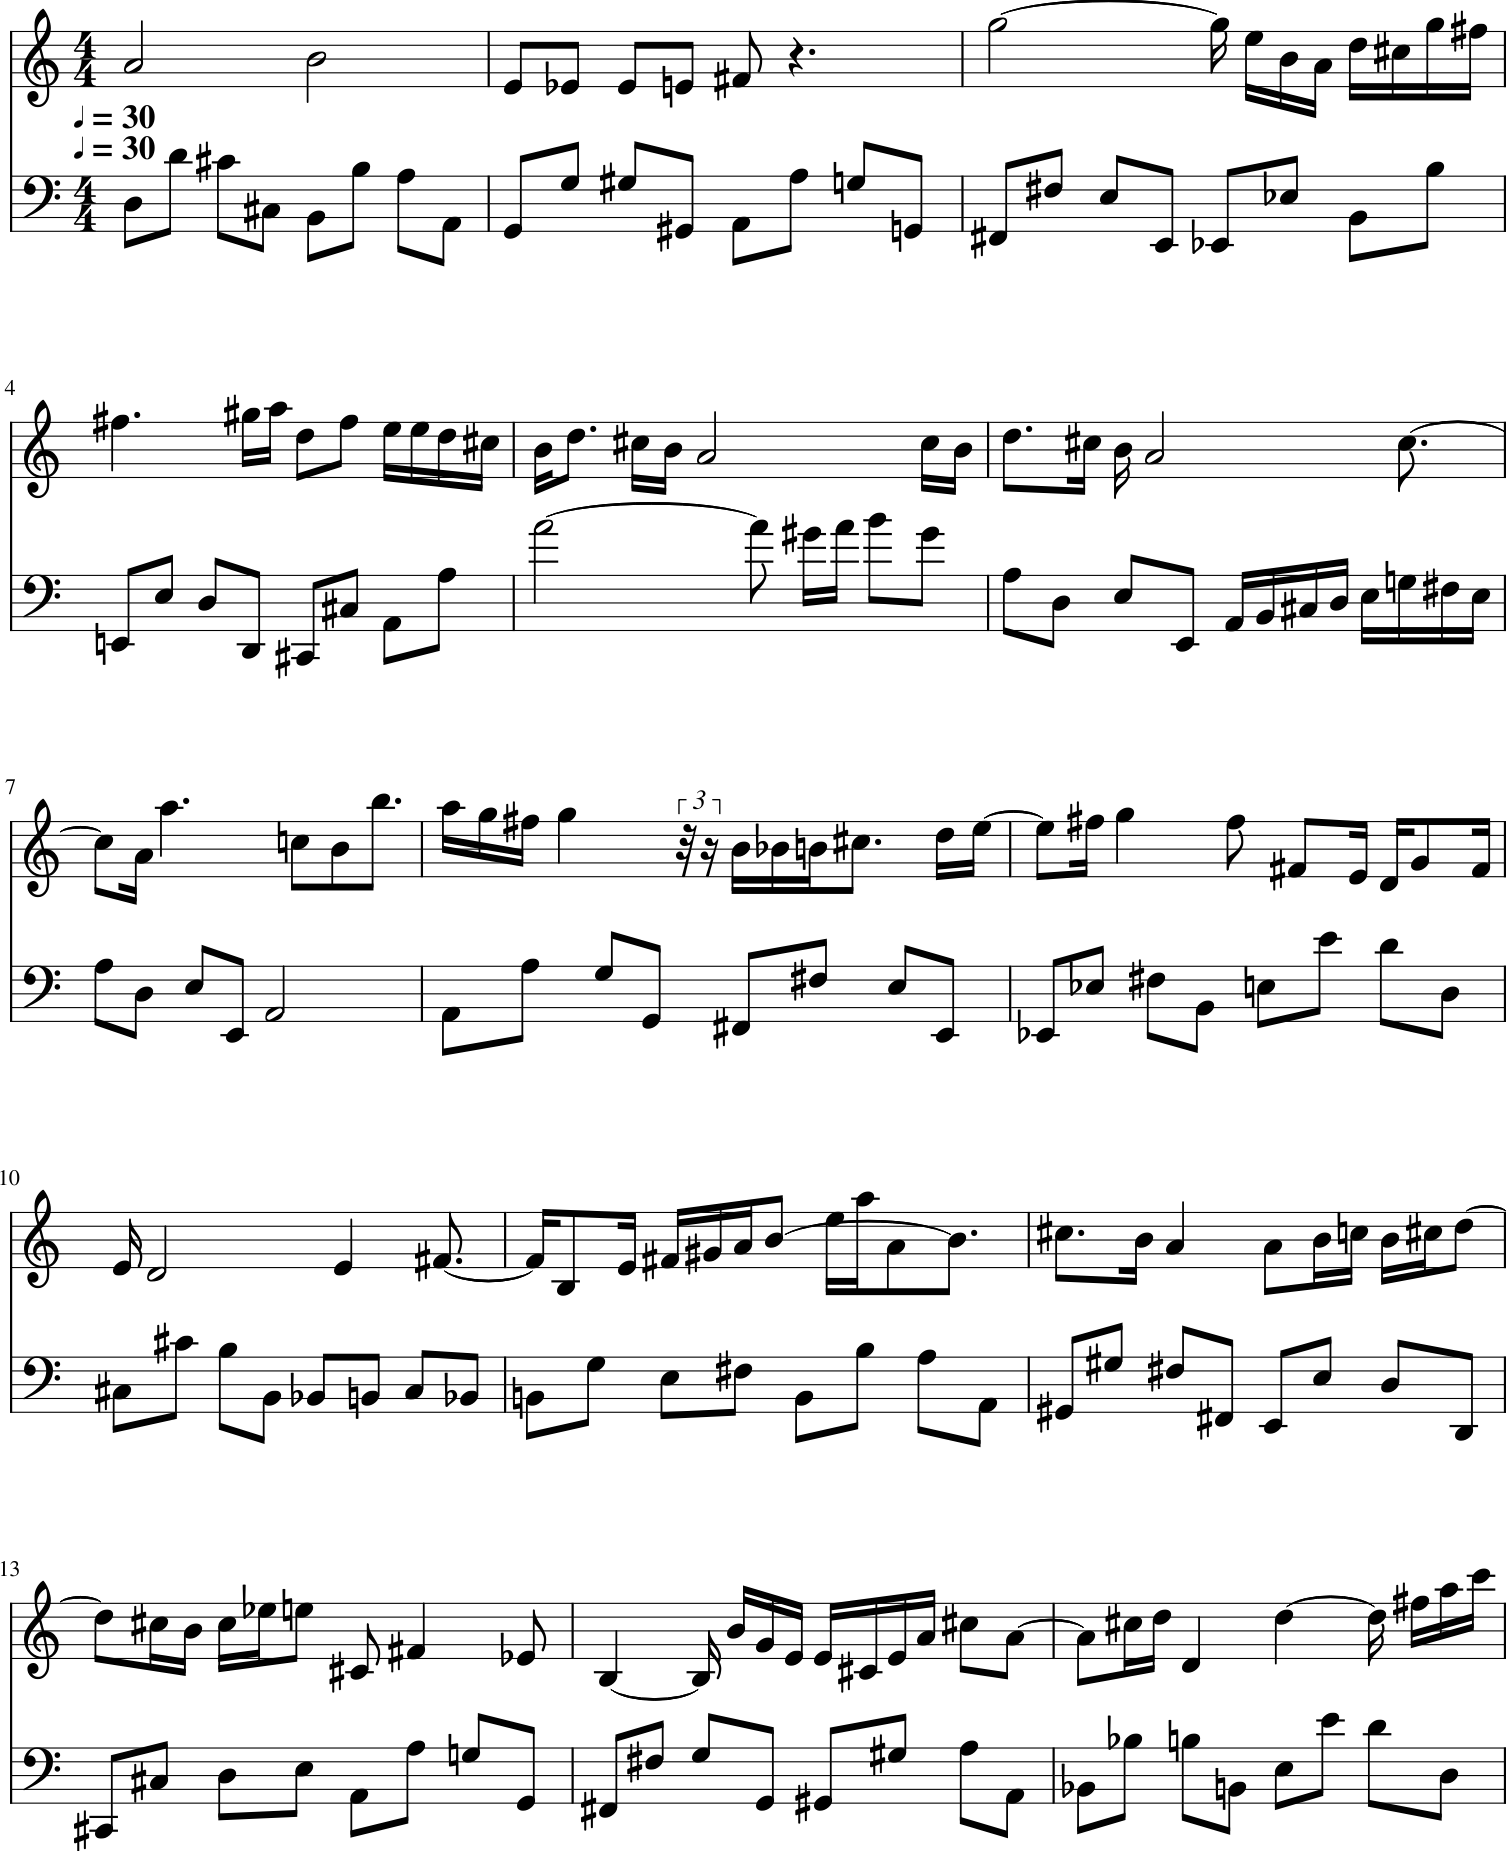

In [65]:
new_arrange.show()

In [66]:
new_arrange.write("midi", "bachblah.mid")

'bachblah.mid'

In [ ]:
playe.play()